# Mass balance type intercomparison with one flowline for Hintereisferner 

In [1]:
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  

from functools import partial
import shutil
import copy
import time
import numpy as np
import pandas as pd
from numpy.testing import assert_allclose
import scipy
from scipy.stats import linregress
import os
import pytest
import matplotlib.pyplot as plt
import xarray as xr
import oggm

# imports from OGGM
from oggm.core import massbalance
from oggm import utils, workflow, tasks, cfg
from oggm.cfg import SEC_IN_DAY, SEC_IN_YEAR, SEC_IN_MONTH
from oggm.exceptions import InvalidWorkflowError, InvalidParamsError

# imports from MBsandbox package modules
from MBsandbox.mbmod_daily_oneflowline import process_era5_daily_data, TIModel, BASENAMES, process_wfde5_data
from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

In [2]:
# get larger figures
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('figure',figsize=(20,10))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
cfg.initialize()

working_dir = '/home/lilianschuster/Schreibtisch/PhD/oggm_files/oneFlowline'
# this needs to be changed if working on another computer
if not os.path.exists(working_dir):
    working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)
    
cfg.PATHS['working_dir'] = working_dir
# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

2021-02-24 08:44:11: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-24 08:44:11: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-24 08:44:11: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-24 08:44:11: oggm.utils: Checking the download verification file checksum...


In [4]:
# get HEF glacier
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                  prepro_base_url=base_url,
                                  prepro_rgi_version='62')
gd = gdirs[0]
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
# oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5_daily')
process_era5_daily_data(gd)

h, w = gd.get_inversion_flowline_hw()
fls = gd.read_pickle('inversion_flowlines')

mbdf = gd.get_ref_mb_data()
pf = 2.5

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-02-24 08:44:12: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-02-24 08:44:12: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-24 08:44:12: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar
2021-02-24 08:44:12: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `ERA5_daily`.
2021-02-24 08:44:12: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
2021-02-24 08:44:15: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.

In [5]:
gd.get_diagnostics()

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'dem_source': 'NASADEM', 'flowline_type': 'elevation_band'}

In [6]:
# check if area of  HUSS flowlines corresponds to the rgi area
np.allclose(gd.rgi_area_m2, np.sum(w * gd.grid.dx * fls[0].dx))

True

# Optimization of the bias:

In [7]:
co = ['green','lightgreen','blue','lightblue','red', 'orange']
loop = False
def plot_mb(gd, mb_type = 'mb_monthly', grad_type = 'cte', N = 100, pf = 2.5 , co ='r'):
    """ plots modelled mb time series with performance statistics as labels """

    gd_mb = TIModel(gd, None, prcp_fac=pf, mb_type=mb_type, grad_type=grad_type, N=N)

    melt_f_opt = scipy.optimize.brentq(minimize_bias,1,10000, args=(gd_mb, gd, 
                                                                    pf, False), disp=True, xtol=0.1)
    gd_mb.melt_f = melt_f_opt
    # check climate and adapt if necessary
    gd_mb.historical_climate_qc_mod(gd)
    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
    RMSD, bias , rcor, quot_std = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
    plt.plot(mbdf.index, mb_specific, color = co,
             label = 'modeled {} {} gradient: RMSD {}, rcor {}, std_quot {}, bias {}'.format(mb_type, grad_type,
                                                                                             RMSD.round(1), rcor.round(3), quot_std.round(3), bias.round(2), ))


2021-02-23 18:02:03: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-23 18:02:03: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 18:02:05: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_temp_monthly.nc verified successfully.
2021-02-23 18:02:08: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_geopotential_monthly.nc verified successfully.
2021-02-23 18:02:23: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_tempstd_monthly.nc verified successfully.
2021-02-23 18:02:24: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 18:02:24: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: Dep

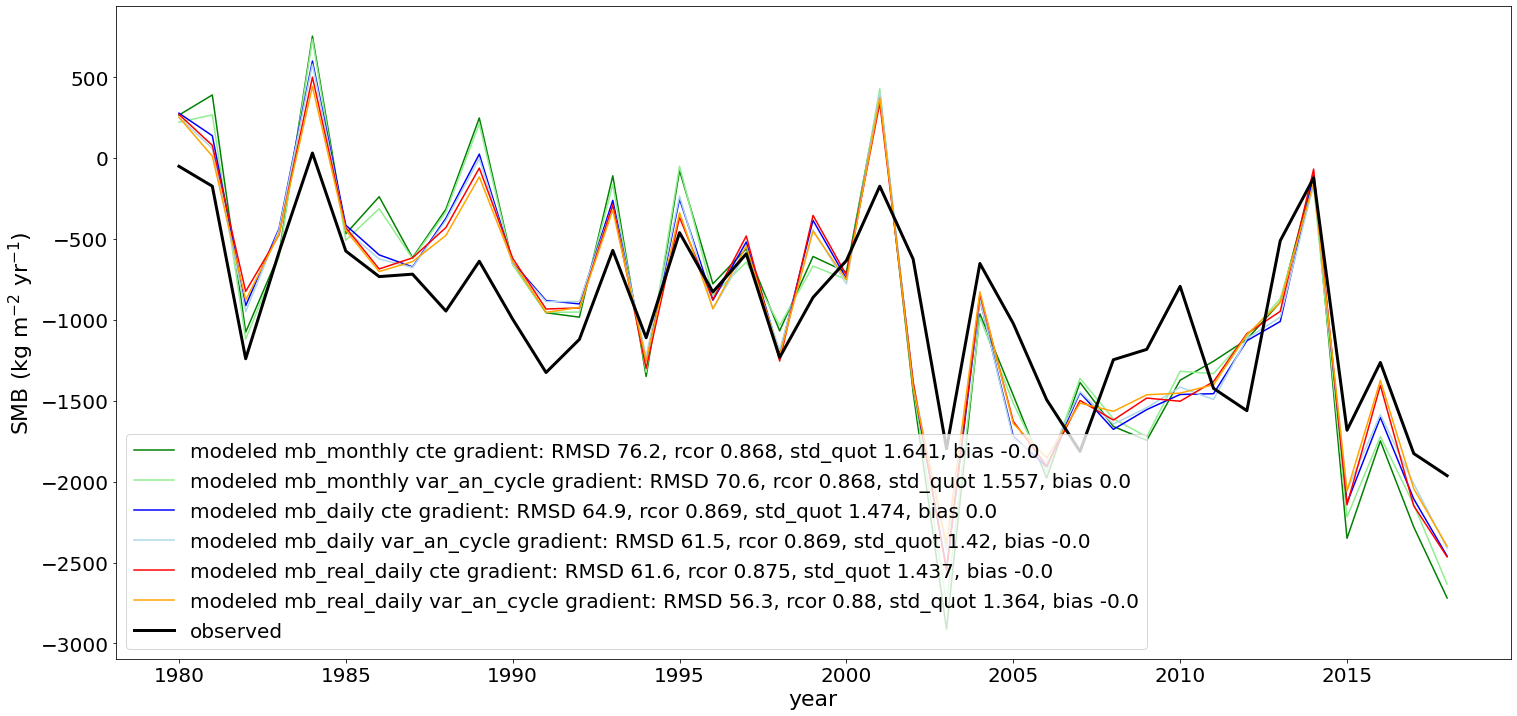

In [11]:
plt.figure(figsize=(25,12))
# for mb_monthly and mb_daily: use ERA5dr climate!
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
j = 0
for mb_type in [ 'mb_monthly','mb_daily']:
    
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j]  )
        j += 1

# fpr mb_real_daily: use ERA5_daily climate!
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_era5_daily_data(gd)

for mb_type in ['mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j] )
        j +=1


plt.plot(mbdf.index,
         mbdf.ANNUAL_BALANCE,
         label = 'observed', color = 'black', lw=3)
plt.legend()
plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');
plt.savefig('./figures_hef/HEF_mb_time_series_mod_obs_6types.pdf')


For WFDE5, the precipitation factor of 2.5 is way too high, we will compute the optimal precipitation factor later:

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-02-24 08:49:44: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `WFDE5_monthly_cru`.
2021-02-24 08:49:44: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_wfde5_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilian

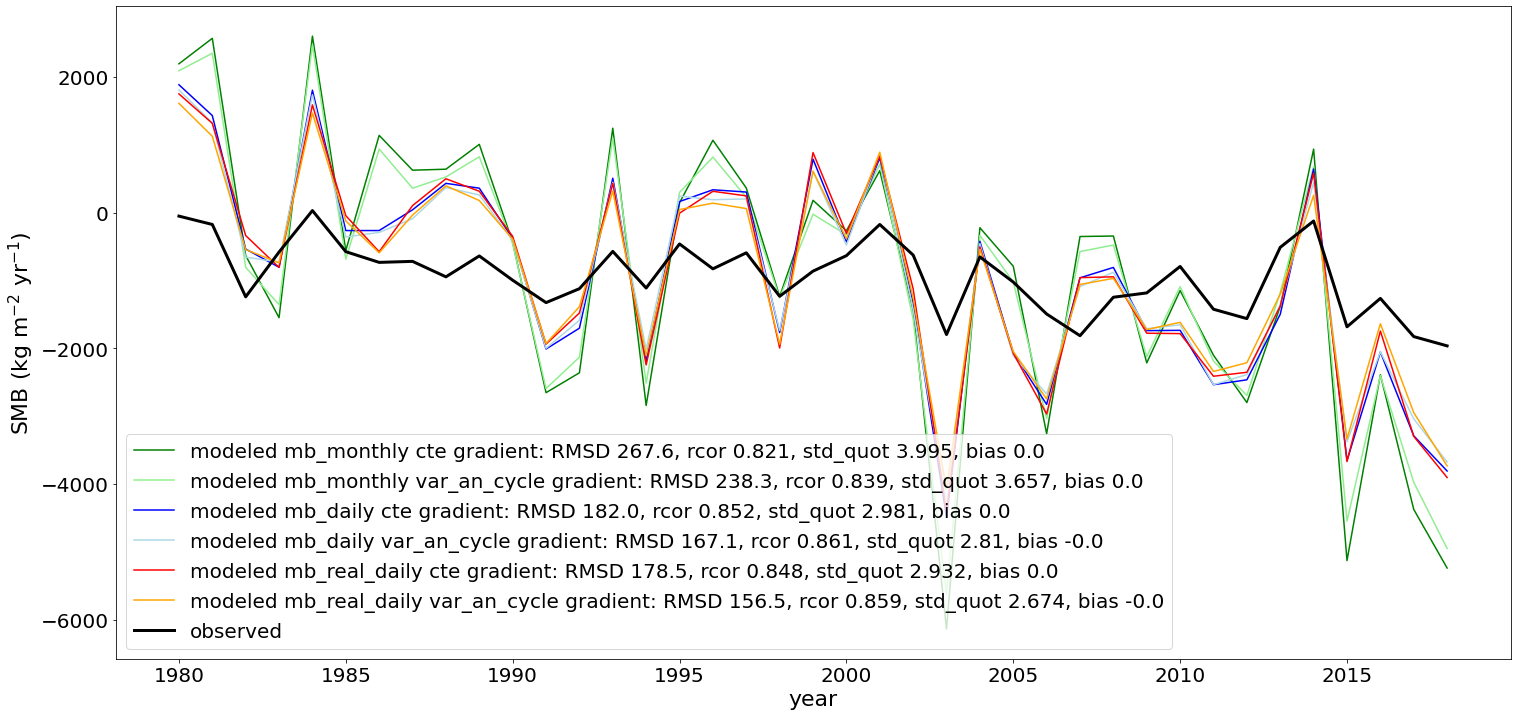

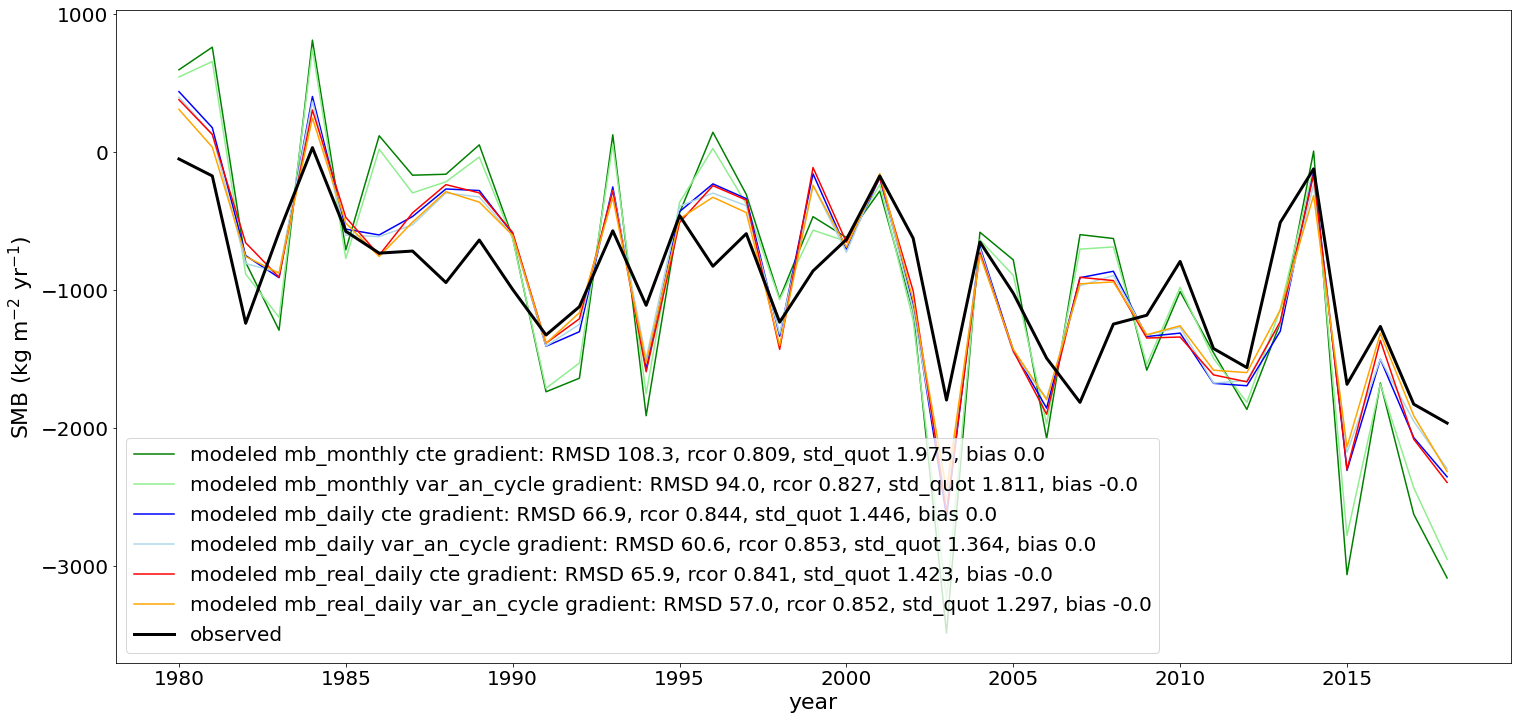

In [12]:
for pf in [2.5, 1]:
    plt.figure(figsize=(25,12))
    # for mb_monthly and mb_daily: use ERA5dr climate!
    cfg.PARAMS['baseline_climate'] = 'WFDE5_monthly_cru'
    process_wfde5_data(gd, temporal_resol='monthly')
    j = 0
    for mb_type in [ 'mb_monthly','mb_daily']:

        for grad in ['cte','var_an_cycle']:
            plot_mb(gd, mb_type = mb_type, grad_type = grad, pf=pf, co =co[j]  )
            j += 1

    # fpr mb_real_daily: use ERA5_daily climate!
    cfg.PARAMS['baseline_climate'] = 'ERA5_daily' # TODO: WFDE5_daily_cru 
    process_wfde5_data(gd, temporal_resol='daily')

    for mb_type in ['mb_real_daily']:
        for grad in ['cte','var_an_cycle']:
            plot_mb(gd, mb_type = mb_type, grad_type = grad, pf=pf, co =co[j] )
            j +=1


    plt.plot(mbdf.index,
             mbdf.ANNUAL_BALANCE,
             label = 'observed', color = 'black', lw=3)
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');
    plt.savefig('./figures_hef/HEF_mb_time_series_mod_obs_6types_WFDE5_pf{}.pdf'.format(pf))


For WFDE5, a precipitation factor of 1 actually represents quite good the mass balance time series

### check optimization time needed for different amount of percentiles that are used in 'mb_daily' to derive the daily temperature out of the standard deviation


In [12]:
pf = 2.5
mb_type = 'mb_daily'
grad = 'var_an_cycle'

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
def plot_optimization_bias_time(optim_type = 'brentq', loop= False):
    """ plots amount the bias versus necessary time for different value of N 
    (N is the amount of values taken out of normal distribution to describe daily temperature from mean and daily std)"""
    c = ['k','grey','blue','lightblue','green','orange','red']
    
    # only instantiate it once
    gd_mb = TIModel(gd, None, mb_type=mb_type, grad_type=grad, prcp_fac=pf, loop=loop, N=100)
    # check climate and adapt if necessary, in this case it is sufficient to do this once!
    gd_mb.historical_climate_qc_mod(gd)
    for j,N in enumerate([1000,  500, 200, 100, 50, 30][::-1]):
        ex_t = time.time()
        # then change N and melt_f accordingly! to save time
        gd_mb.N = int(N)
        if optim_type =='brentq':  
            gd_mb.melt_f = scipy.optimize.brentq(minimize_bias, 10, 10000, args=(gd_mb, gd, pf, False), disp=True, xtol=0.1)
        elif optim_type =='powell':
            gd_mb.melt_f = scipy.optimize.minimize(minimize_bias, [100], args=(gd_mb, gd, pf, False), method = 'Powell').x

        mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,
                                             year = mbdf.index.values)
        stats = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
        ex_time = time.time() - ex_t
        if loop: 
            plt.plot(ex_time, stats[1],'o',color = c[j],
                     label = '{} loop'.format(N))
        else: 
            plt.plot(ex_time, stats[1],'x',color = c[j],
                 label = '{} noloop'.format(N))

2021-02-23 19:11:04: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


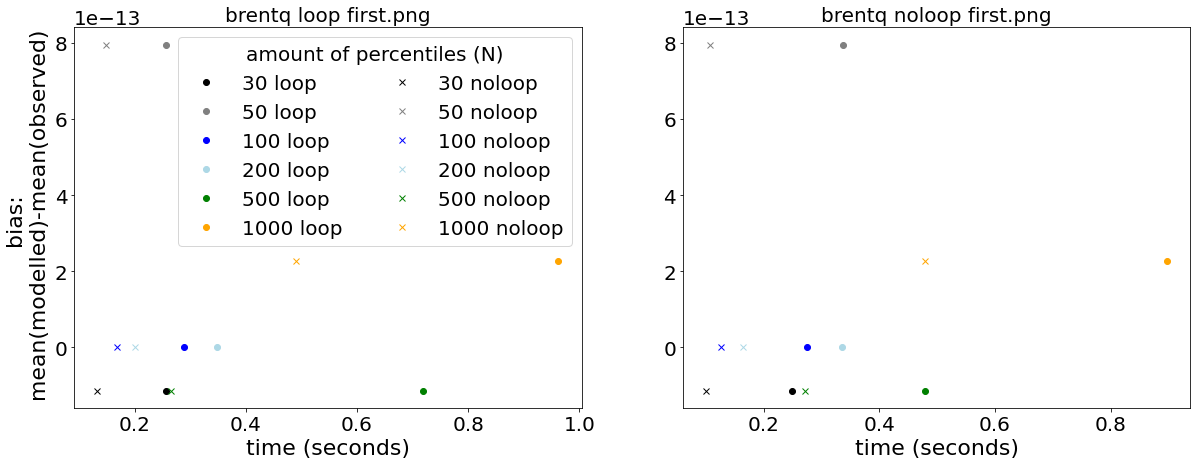

In [48]:
# %%
warnings.filterwarnings('ignore')

cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
plt.figure(figsize=(20,7))
plt.subplot(121)
plot_optimization_bias_time(optim_type = 'brentq', loop= True )
plot_optimization_bias_time(optim_type = 'brentq', loop= False )
plt.legend(title='amount of percentiles (N)', ncol = 2)
plt.ylabel('bias: \n mean(modelled)-mean(observed)')
plt.xlabel('time (seconds)')
plt.title('brentq loop first.png')
plt.subplot(122)
plot_optimization_bias_time(optim_type = 'brentq', loop= False )
plot_optimization_bias_time(optim_type = 'brentq', loop= True )        
plt.xlabel('time (seconds)')
plt.title('brentq noloop first.png')

plt.savefig('./figures_hef/optimiser_time_comparison_HEF.pdf')


- noloop is most of the times faster 
- Brentq is much faster
- actually it does not matter which N is used for the computation ... 
    - all calibrate well: so can set N=100, just to have a bit more percentiles than days

# Calibrate additionally the precipitation factor for each glacier such that the standard deviation of modelled and reference mass balance are similar

In [13]:
ddf_opt_pf = {}
ddf_opt = {}
ddf_opt_pf = {}
pf_opt = {}

ddf_opt_pf_wfde5 = {}
ddf_opt_wfde5 = {}
ddf_opt_pf_wfde5 = {}
pf_opt_wfde5 = {}

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
N = 100
loop = False


for mb_type in ['mb_monthly', 'mb_daily','mb_real_daily']: 
    if mb_type == 'mb_monthly' or mb_type =='mb_daily':
        cfg.PARAMS['baseline_climate'] = 'ERA5dr'
        oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
    else:
        cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
        process_era5_daily_data(gd) 
    for grad in ['cte','var_an_cycle']:
        ex_t = time.time()
        gd_mb = TIModel(gd, None, mb_type=mb_type, grad_type=grad, prcp_fac=2.5, loop=loop, N=N)
        # check climate and adapt if necessary, in this case it is sufficient to do this once!
        gd_mb.historical_climate_qc_mod(gd)
        # first get the optimal ddf with the default precipitation factor (pf)
        ddf_opt[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias, 10, 10000,
                                                         args=(gd_mb, gd, 2.5, False), disp=True, xtol=0.1)
                
        # calibrate the optimal precipitation factor
        # in 'optimize_std_quot_brentq' for each pf an optimal DDF is found, 
        # then 1- standard deviation quotient between modelled and reference mass balance is computed, which is then minimised
        pf_opt[mb_type+'_'+grad] = scipy.optimize.brentq(optimize_std_quot_brentq, 0.01, 20,
                                           args=(gd_mb, gd),
                                           xtol=0.01)
        
        # the optimal ddf with the optimal precipitation factor is computed again 
        ddf_opt_pf[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias, 10, 10000,
                                                         args=(gd_mb, gd, pf_opt[mb_type+'_'+grad], False),
                                                             disp=True, xtol=0.1)
        

        ex_time = time.time() - ex_t
        print(ex_time)
        
for mb_type in ['mb_monthly', 'mb_daily','mb_real_daily']: 
    if mb_type == 'mb_monthly' or mb_type =='mb_daily':
        cfg.PARAMS['baseline_climate'] = 'WFDE5_monthly_cru'
        process_wfde5_data(gd, temporal_resol='monthly')
    else:
        # fpr mb_real_daily: use ERA5_daily climate!
        cfg.PARAMS['baseline_climate'] = 'ERA5_daily' # TODO: WFDE5_daily_cru 
        process_wfde5_data(gd, temporal_resol='daily')        
        
    for grad in ['cte','var_an_cycle']:
        ex_t = time.time()
        gd_mb = TIModel(gd, None, mb_type=mb_type, grad_type=grad, prcp_fac=2.5, loop=loop, N=N)
        # check climate and adapt if necessary, in this case it is sufficient to do this once!
        gd_mb.historical_climate_qc_mod(gd)
        # first get the optimal ddf with the default precipitation factor (pf)
        ddf_opt_wfde5[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias, 10, 10000,
                                                         args=(gd_mb, gd, 2.5, False), disp=True, xtol=0.1)
                
        # calibrate the optimal precipitation factor
        # in 'optimize_std_quot_brentq' for each pf an optimal DDF is found, 
        # then 1- standard deviation quotient between modelled and reference mass balance is computed, which is then minimised
        pf_opt_wfde5[mb_type+'_'+grad] = scipy.optimize.brentq(optimize_std_quot_brentq, 0.01, 20,
                                           args=(gd_mb, gd),
                                           xtol=0.01)
        
        # the optimal ddf with the optimal precipitation factor is computed again 
        ddf_opt_pf_wfde5[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias, 10, 10000,
                                                         args=(gd_mb, gd, pf_opt_wfde5[mb_type+'_'+grad], False),
                                                             disp=True, xtol=0.1)
        

        ex_time = time.time() - ex_t
        print(ex_time)



2021-02-24 08:55:49: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-24 08:55:49: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-24 08:55:59: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_tempstd_monthly.nc verified successfully.


0.3628535270690918


2021-02-24 08:56:00: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


0.36426568031311035
0.8633170127868652


2021-02-24 08:56:01: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-24 08:56:01: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data


0.8641355037689209


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)


0.6737427711486816


2021-02-24 08:56:06: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `WFDE5_monthly_cru`.
2021-02-24 08:56:06: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_wfde5_data


0.6771543025970459


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument 

0.3068714141845703


2021-02-24 08:56:08: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_wfde5_data


0.317645788192749


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument 

0.8933100700378418


2021-02-24 08:56:11: oggm.cfg: PARAMS['baseline_climate'] changed from `WFDE5_monthly_cru` to `ERA5_daily`.
2021-02-24 08:56:11: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_wfde5_data


0.880122184753418


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument 

0.6953260898590088
0.6989266872406006


In [21]:
# produce a pd Dataframe 
li = []
for mb_type in ['mb_monthly','mb_daily','mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        li.append(mb_type+'_'+grad)
        li.append(mb_type+'_'+grad+'_pf')        


pd_stats = pd.DataFrame(columns = ['RMSD','bias','rcor','std_quot'], index = li, data = np.NaN)
pd_stats['pf'] = 2.5
pd_stats['DDF'] = np.NaN
for k in ddf_opt.keys():
    pd_stats.loc[k,'DDF'] = ddf_opt[k]
for k in ddf_opt_pf.keys():
    kk = k +'_pf'
    pd_stats.loc[kk,'DDF'] = ddf_opt_pf[k]
for k in pf_opt.keys():
    kk = k +'_pf'
    pd_stats.loc[kk,'pf'] = pf_opt[k]
# wfde5
pd_stats_wfde5 = pd.DataFrame(columns = ['RMSD','bias','rcor','std_quot'], index = li, data = np.NaN)
pd_stats_wfde5['pf'] = 2.5
pd_stats_wfde5['DDF'] = np.NaN
for k in ddf_opt_wfde5.keys():
    pd_stats_wfde5.loc[k,'DDF'] = ddf_opt_wfde5[k]
for k in ddf_opt_pf_wfde5.keys():
    kk = k +'_pf'
    pd_stats_wfde5.loc[kk,'DDF'] = ddf_opt_pf_wfde5[k]
for k in pf_opt_wfde5.keys():
    kk = k +'_pf'
    pd_stats_wfde5.loc[kk,'pf'] = pf_opt_wfde5[k]

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
def plot_HEF_mb_stats_melt_f_pf_opt(dataset='ERA5', pd_stats = pd_stats, ddf_opt = ddf_opt, ddf_opt_pf = ddf_opt_pf, pf_opt = pf_opt):
    c =['green','lightgreen','blue','lightblue','red', 'orange']
    statis = ['RMSD','bias','rcor','std_quot']
    mbdf = gd.get_ref_mb_data()

    fig = plt.figure(constrained_layout=True, figsize=(25,20))
    gs = fig.add_gridspec(2, 6)

    ax1 = fig.add_subplot(gs[0, :])
    j = 0
    if dataset == 'ERA5':
        cfg.PARAMS['baseline_climate'] = 'ERA5dr'
        oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
    elif dataset == 'WFDE5':
        cfg.PARAMS['baseline_climate'] = 'WFDE5_monthly_cru'
        process_wfde5_data(gd, temporal_resol='monthly')
    for mb_type in [ 'mb_monthly','mb_daily']:

        for grad in ['cte','var_an_cycle']:

            # default pf = 2.5
            gd_mb = TIModel(gd, ddf_opt[mb_type+'_'+grad],   mb_type=mb_type, N=N,
                               grad_type=grad, prcp_fac = 2.5) 
            mb_mod = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
            pd_stats.loc[mb_type+'_'+grad,statis] = compute_stat(mb_specific=mb_mod, mbdf=mbdf)
            label = mb_type[3:]+'_'+grad
            plt.plot(mbdf.index, mb_mod, label = label, color = c[j])

            # optimal pf
            gd_mb_pf = TIModel(gd, ddf_opt_pf[mb_type+'_'+grad],   mb_type=mb_type, N= N,
                                  grad_type=grad, prcp_fac = pf_opt[mb_type+'_'+grad]) 
            # check climate and adapt if necessary
            gd_mb_pf.historical_climate_qc_mod(gd)
            mb_mod_pf = gd_mb_pf.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
            pd_stats.loc[mb_type+'_'+grad+'_pf',statis] = compute_stat(mb_specific=mb_mod_pf, mbdf=mbdf)
            label = mb_type[3:]+'_'+grad+'_pf_opt'
            plt.plot(mbdf.index, mb_mod_pf,
                     '--', label =label, color = c[j])
            j +=1
        if mb_type == 'mb_monthly':
            # also plot the observed mass balance 
            plt.plot(mbdf.index,
             mbdf.ANNUAL_BALANCE,
             label = 'observed', color = 'black', lw=3)
    if dataset =='ERA5':        
        cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
        process_era5_daily_data(gd)
    elif dataset == 'WFDE5':
        cfg.PARAMS['baseline_climate'] = 'ERA5_daily' # TODO: WFDE5_daily_cru 
        process_wfde5_data(gd, temporal_resol='daily') 
    for mb_type in ['mb_real_daily']:
        for grad in ['cte','var_an_cycle']:
            # for pf = 2.5
            gd_mb = TIModel(gd, ddf_opt[mb_type+'_'+grad],   mb_type=mb_type,N=N,
                               grad_type=grad, prcp_fac = 2.5) 
            mb_mod = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
            pd_stats.loc[mb_type+'_'+grad,statis] = compute_stat(mb_specific=mb_mod, mbdf=mbdf)
            label = mb_type[3:]+'_'+grad

            # for optimal pf 
            gd_mb_pf = TIModel(gd, ddf_opt_pf[mb_type+'_'+grad],   mb_type=mb_type, N=N,
                                  grad_type=grad, prcp_fac = pf_opt[mb_type+'_'+grad])
            # check climate and adapt if necessary
            gd_mb_pf.historical_climate_qc_mod(gd)
            mb_mod_pf = gd_mb_pf.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
            pd_stats.loc[mb_type+'_'+grad+'_pf',statis] = compute_stat(mb_specific=mb_mod_pf, mbdf=mbdf)
            plt.plot(mbdf.index, mb_mod, label = label, color = c[j])
            label = mb_type[3:]+'_'+grad+'_pf_opt'
            plt.plot(mbdf.index, mb_mod_pf,
                     '--', label =label, color = c[j])
            j +=1


    plt.xlabel('year')
    plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)')
    plt.legend(ncol = 3)

    for st,f in zip(['RMSD','bias', 'rcor', 'std_quot', 'pf', 'DDF'],
                    [0,1,2,3,4,5]):
        ax_f = fig.add_subplot(gs[1, f])
        for j,r in enumerate(pd_stats[st][::2]):
            plt.plot(st, r,'o', color = c[j], markersize=10,
                     label = 'pf=2.5')# [~np.isna*n(pd_stats['RMSD'].values) 
            plt.axhline(pd_stats[st][j*2+1],ls='--', color = c[j], lw=2,
                        label = 'optimal pf')# [~np.isnan(pd_stats['RMSD'].values) 
            if j ==0 and f ==0:
                plt.legend(loc = 2)
                plt.ylim([40,83])
    plt.suptitle('applied climate dataset: {}'.format(dataset))
    plt.tight_layout()
    plt.savefig('./figures_hef/HEF_mb_stats_mod_obs_12types_pfopt_stats_{}.pdf'.format(dataset))
    return pd_stats

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-02-24 09:20:31: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-02-24 09:20:31: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-24 09:20:31: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-24 09:20:31: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each d

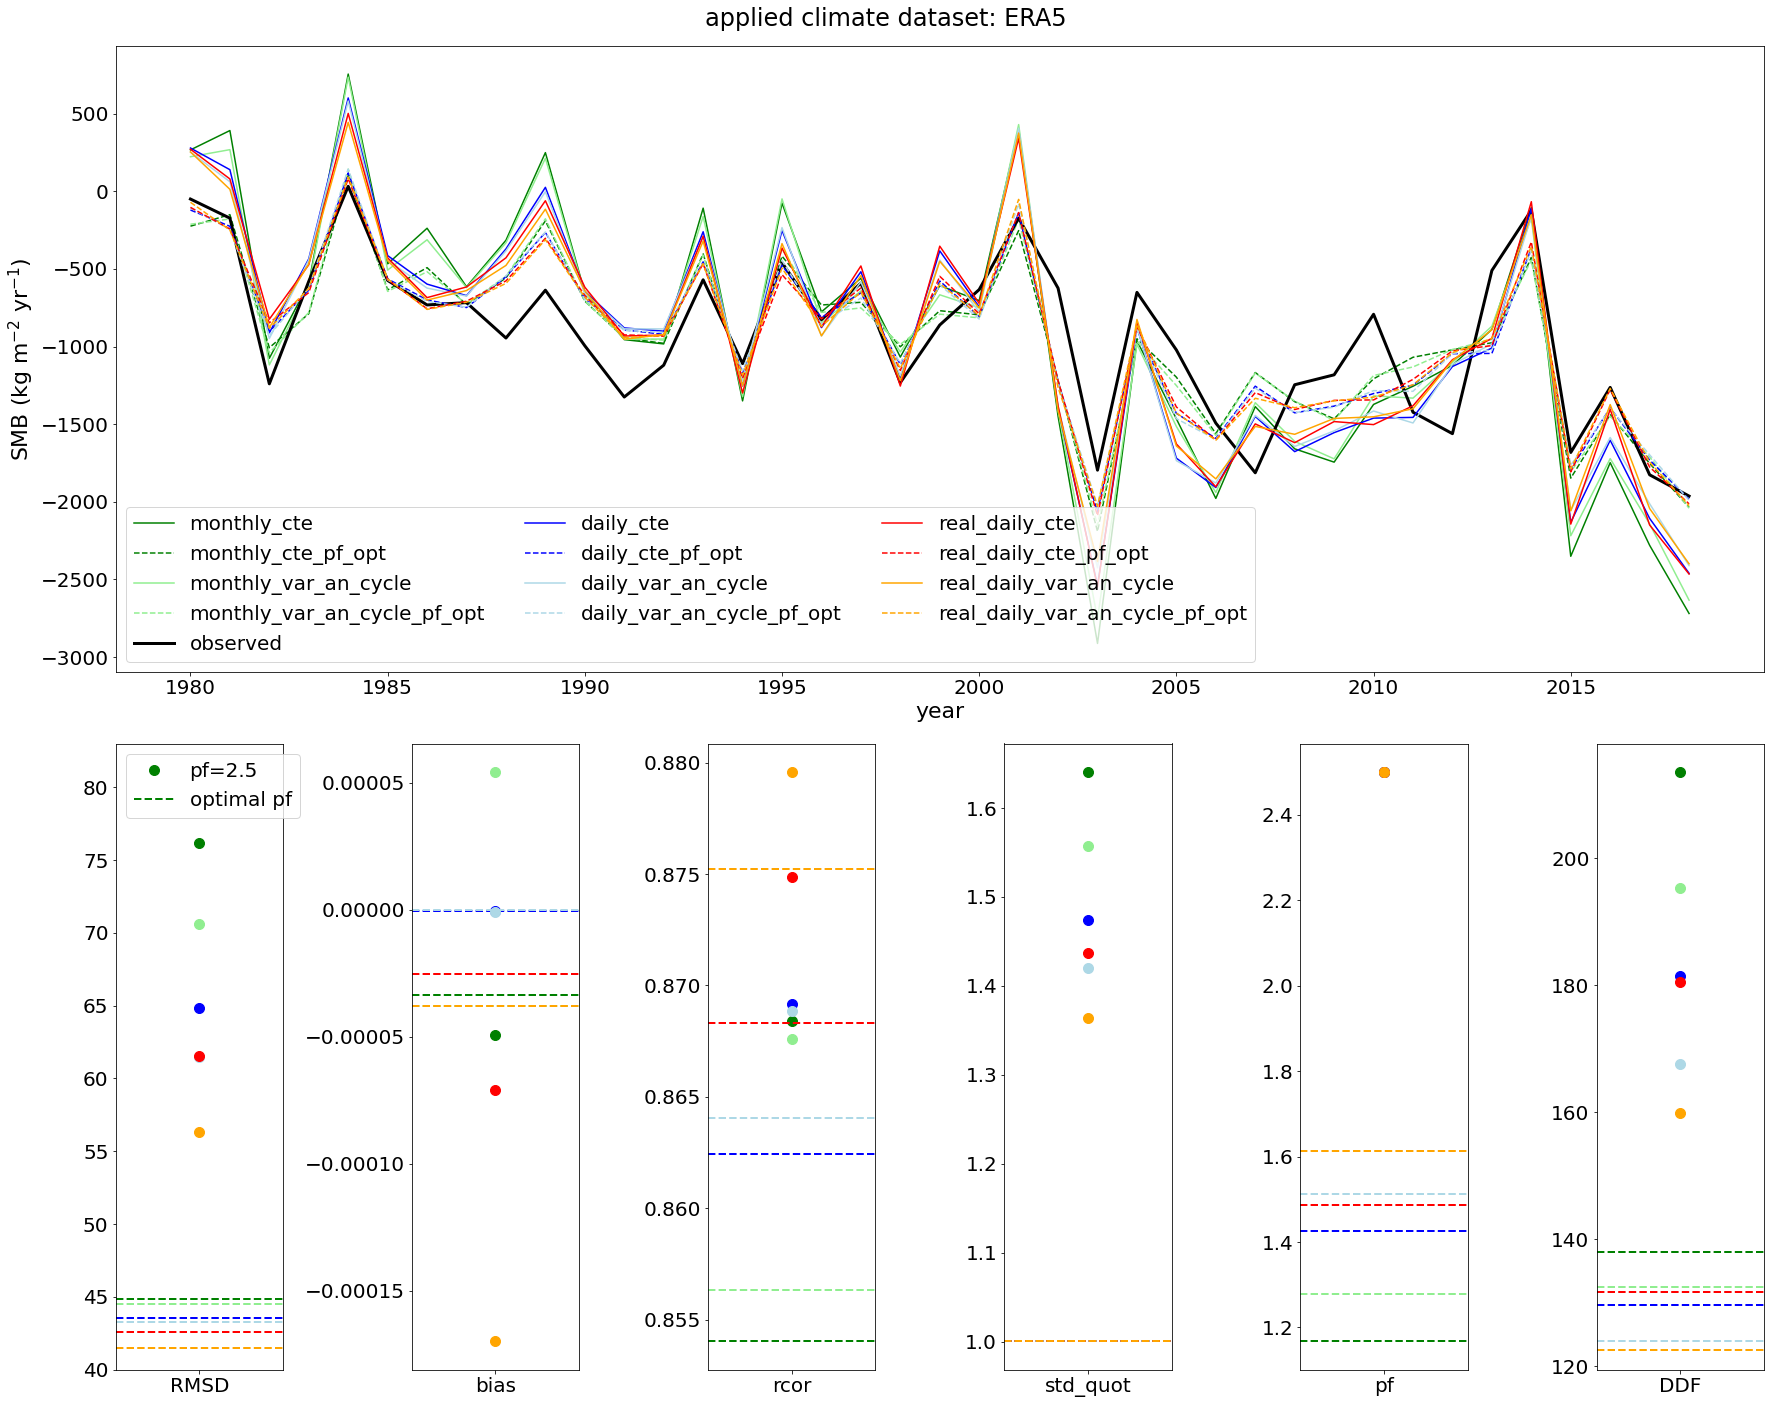

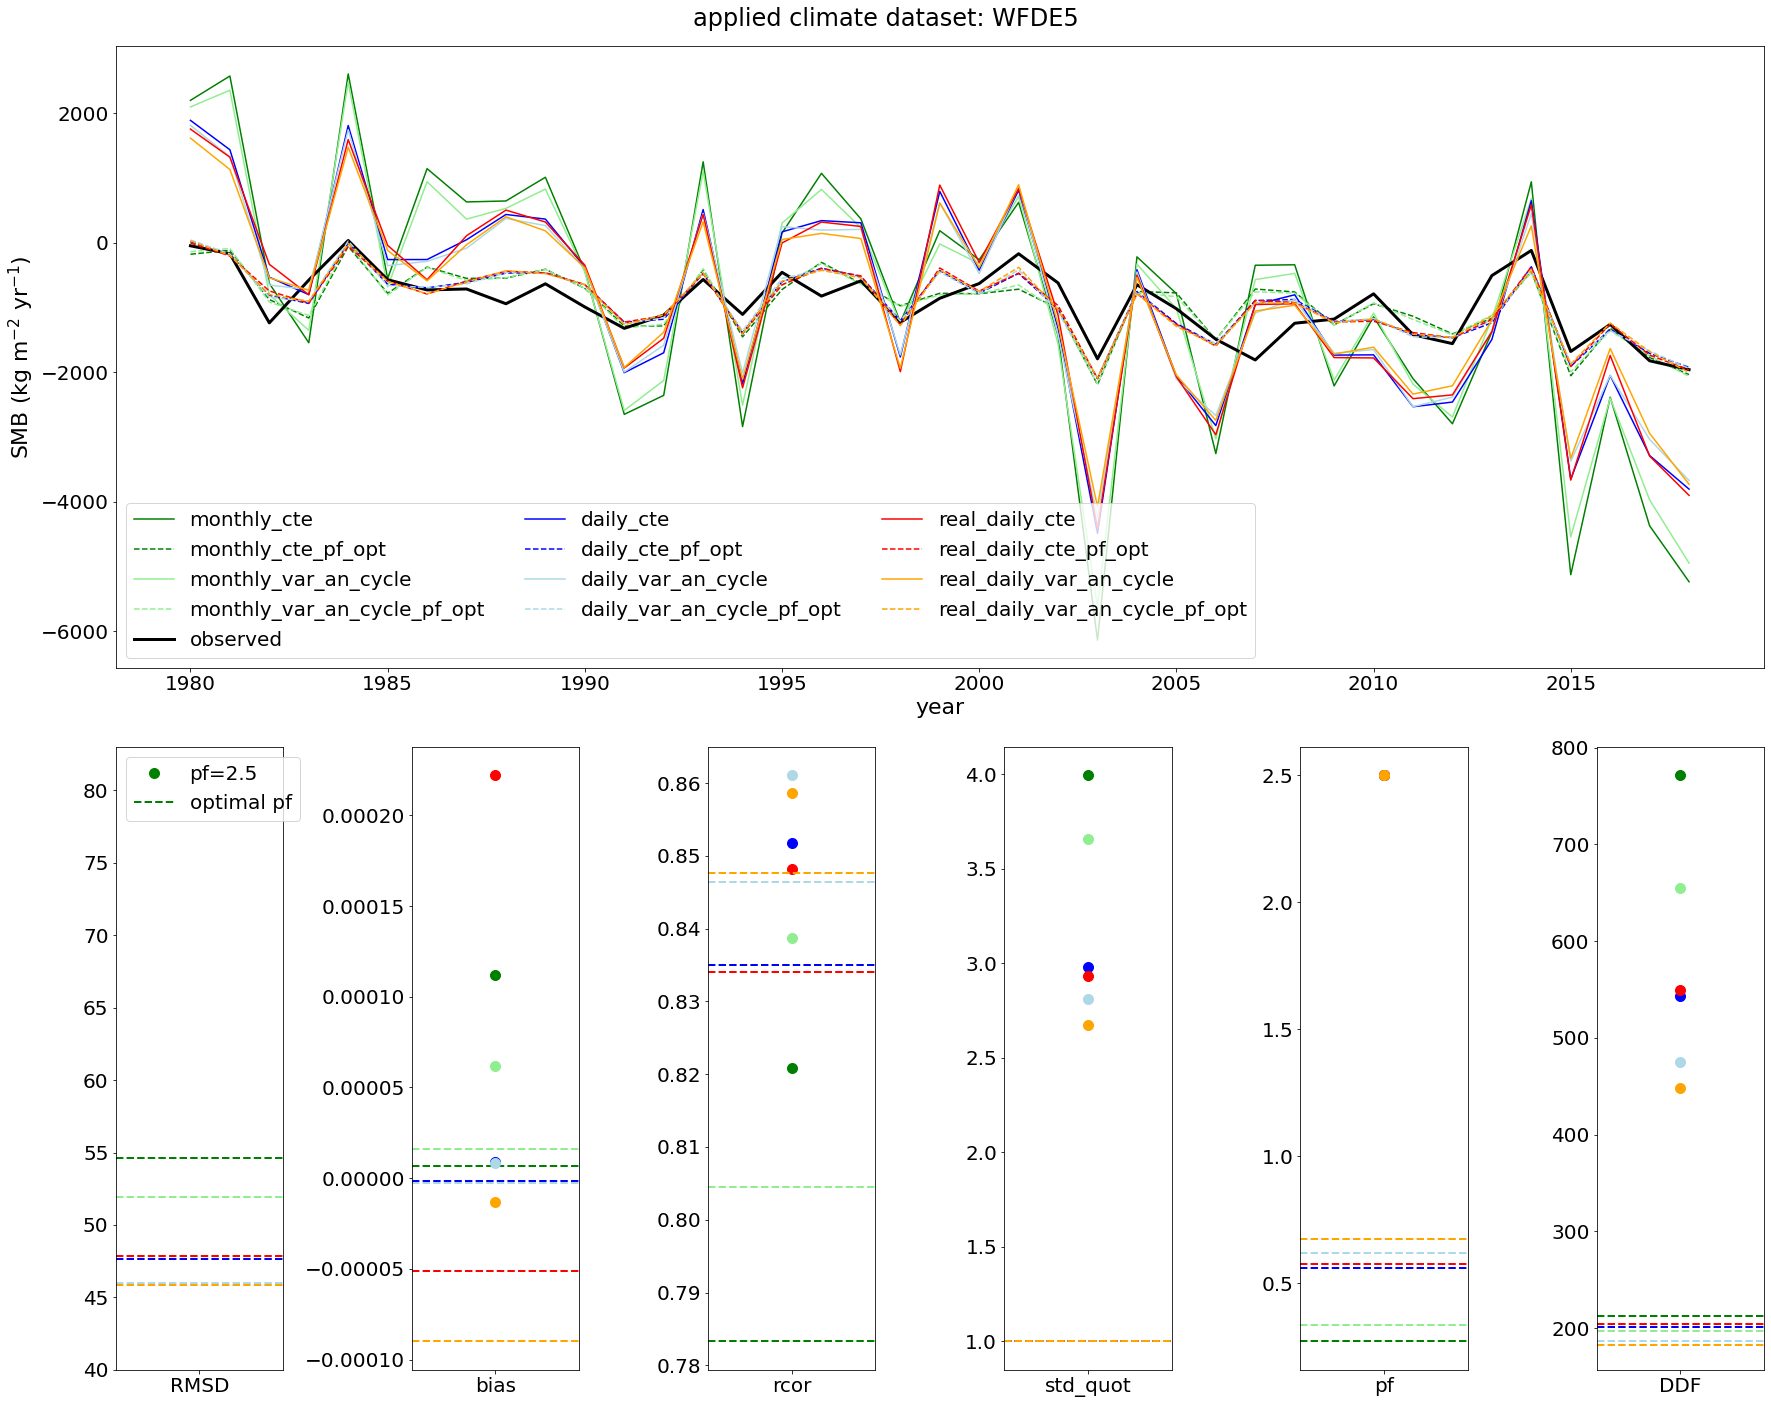

In [28]:
pd_stats = plot_HEF_mb_stats_melt_f_pf_opt(dataset='ERA5', pd_stats=pd_stats)
pd_stats_wfde5 = plot_HEF_mb_stats_melt_f_pf_opt(dataset='WFDE5', pd_stats=pd_stats_wfde5,
                                                ddf_opt = ddf_opt_wfde5, ddf_opt_pf = ddf_opt_pf_wfde5, pf_opt = pf_opt_wfde5)

In [29]:
pd_stats
# actually now it runs quite fast, so I don' need to store it anymore
# pd_stats.to_csv('stats_opt_N_{}_{}.csv'.format(N, gd.rgi_id))

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,RMSD,bias,rcor,std_quot,pf,DDF
mb_monthly_cte,76.158152,-4.924633e-05,0.868383,1.640549,2.500000,213.561412
mb_monthly_cte_pf,44.852991,-3.347719e-05,0.854022,1.000511,1.167568,137.974667
mb_monthly_var_an_cycle,70.575782,5.416301e-05,0.867590,1.557466,2.500000,195.322803
mb_monthly_var_an_cycle_pf,44.498451,-3.783596e-05,0.856336,1.000616,1.278970,132.463223
mb_daily_cte,64.867149,-6.417594e-07,0.869174,1.474495,2.500000,181.383413
mb_daily_cte_pf,43.546548,-5.505534e-07,0.862417,1.000615,1.426330,129.652929
mb_daily_var_an_cycle,61.478986,-8.637732e-07,0.868876,1.420001,2.500000,167.506525
mb_daily_var_an_cycle_pf,43.291077,-1.237856e-07,0.864038,1.000700,1.512758,123.920505
mb_real_daily_cte,61.550666,-7.098777e-05,0.874869,1.436538,2.500000,180.419554
mb_real_daily_cte_pf,42.603747,-2.547756e-05,0.868298,1.000531,1.486530,131.704817


In [31]:
pd_stats_wfde5.DDF


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


mb_monthly_cte                   771.551467
mb_monthly_cte_pf                212.326661
mb_monthly_var_an_cycle          655.302131
mb_monthly_var_an_cycle_pf       196.963961
mb_daily_cte                     543.876657
mb_daily_cte_pf                  201.082106
mb_daily_var_an_cycle            475.066298
mb_daily_var_an_cycle_pf         186.259902
mb_real_daily_cte                549.601950
mb_real_daily_cte_pf             204.678110
mb_real_daily_var_an_cycle       447.945251
mb_real_daily_var_an_cycle_pf    182.779733
Name: DDF, dtype: float64

In [56]:
t, tfmelt, prcp, prcpsol = gd_mb._get_2d_annual_climate(h, year=2016) # this corresponds to the climate data of October 2017

In [58]:
type(2017.9)

float

In [48]:
gd_mb.get_annual_mb(h, year = 2017)

array([ 8.01541033e-09,  2.36688106e-09, -4.29007964e-09, -8.96656216e-09,
       -1.33188889e-08, -1.79582266e-08, -2.16873787e-08, -2.53663003e-08,
       -2.95718089e-08, -3.37957103e-08, -3.80534363e-08, -4.20331425e-08,
       -4.55851098e-08, -4.91018697e-08, -5.26743910e-08, -5.64902882e-08,
       -6.05182550e-08, -6.40990641e-08, -6.70364649e-08, -6.92547655e-08,
       -7.13626271e-08, -7.30331630e-08, -7.47167393e-08, -7.62316078e-08,
       -7.76822723e-08, -7.91556112e-08, -8.07734867e-08, -8.25061795e-08,
       -8.42916445e-08, -8.70114490e-08, -8.95389768e-08, -9.13738937e-08,
       -9.32142040e-08, -9.46926007e-08, -9.60569287e-08, -9.74117687e-08,
       -9.88850991e-08, -1.00444835e-07, -1.02012716e-07, -1.03695252e-07,
       -1.05488923e-07, -1.07292521e-07, -1.09478702e-07, -1.11733001e-07,
       -1.13897428e-07, -1.16004748e-07, -1.18235891e-07, -1.20607322e-07,
       -1.23037829e-07, -1.25939563e-07, -1.29117535e-07, -1.33118247e-07,
       -1.37623671e-07, -

In [50]:
gd_mb.get_monthly_mb(h, year = 2018.8)

array([-7.50615329e-08, -9.19331654e-08, -1.15489124e-07, -1.35417237e-07,
       -1.55216554e-07, -1.76292250e-07, -1.92944059e-07, -2.09233210e-07,
       -2.27416600e-07, -2.44960595e-07, -2.62189633e-07, -2.77996118e-07,
       -2.91519617e-07, -3.03947207e-07, -3.16142497e-07, -3.28729230e-07,
       -3.41862060e-07, -3.53324370e-07, -3.62595897e-07, -3.69563149e-07,
       -3.76190955e-07, -3.81398065e-07, -3.86605201e-07, -3.91293878e-07,
       -3.95725379e-07, -4.00156853e-07, -4.04940005e-07, -4.09993056e-07,
       -4.15170516e-07, -4.23097267e-07, -4.30353359e-07, -4.35597062e-07,
       -4.40840686e-07, -4.45067162e-07, -4.48998887e-07, -4.52930612e-07,
       -4.57218815e-07, -4.61746440e-07, -4.66274066e-07, -4.71059076e-07,
       -4.76043923e-07, -4.81040125e-07, -4.87117113e-07, -4.93194152e-07,
       -4.98799673e-07, -5.04193228e-07, -5.09733306e-07, -5.15544807e-07,
       -5.21448846e-07, -5.28418549e-07, -5.35915510e-07, -5.45249718e-07,
       -5.55754206e-07, -

### Check how fast opt_pf works

- with Brentq it works quite fast, but we will not go deeper into this because we will use geodetic MB measurements anyway!

In [59]:
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
mb_type = 'mb_daily'
grad_type = 'cte'

2021-02-23 19:13:38: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


In [62]:
# If I calibrate first the pf and then calibrate again DDF, however if I get a DDF that 
# gives not the perfect std_quotient
loop = False

gd_mb = TIModel(gd, None, prcp_fac=2.5,
                mb_type=mb_type,
                grad_type=grad_type, N=N)
for j,N in enumerate([10000, 5000, 2000,1000,500,100, 50][::-1]):
    ex_t = time.time()
    gd_mb.N = N
    gd_mb.prcp_fac = scipy.optimize.brentq(optimize_std_quot_brentq, 0.01, 20,
                                           args=(gd_mb, gd),
                                           xtol=0.01)
    gd_mb.melt_f = scipy.optimize.brentq(minimize_bias, 1, 10000,
                                               disp=True, xtol=0.1,
                                               args=(gd_mb, gd,
                                                     gd_mb.prcp_fac, False))

    # check climate and adapt if necessary
    gd_mb.historical_climate_qc_mod(gd)
    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,
                                         year = mbdf.index.values)
    stats = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
    ex_time = time.time() - ex_t
    print(ex_time, N, stats, gd_mb.prcp_fac, gd_mb.melt_f)


0.7224397659301758 50 [43.552699408685726, 3.410605131648481e-13, 0.8623777605751793, 1.0006153331741507] 1.4240797236196252 129.7899983022149
0.79437255859375 100 [43.546548884594365, 3.410605131648481e-13, 0.8624166268176926, 1.000615324726867] 1.426329547008846 129.6529286166228
1.721114158630371 500 [43.53576867825211, -1.1368683772161603e-13, 0.8624847551834317, 1.000615451817681] 1.4283524064836688 129.55149534373217
3.026508331298828 1000 [43.53423910712121, 0.0, 0.8624944369057234, 1.0006155898216367] 1.4286240186076424 129.53980268752628
5.605035781860352 2000 [43.53363911135608, 0.0, 0.8624982281843234, 1.000615597448003] 1.428760519154283 129.53410282733188
13.318227767944336 5000 [43.533348228877706, 0.0, 0.8625000632192806, 1.0006155795072207] 1.4288417361693955 129.5307435990877
30.065011501312256 10000 [43.533269560455814, 1.1368683772161603e-12, 0.8625005703073775, 1.0006156529691725] 1.4288682773907566 129.52963711695566


# Check why the mass balance profile of the new TIModel does not match the mb profiles

- I do not understand why the mass balance profile does not coincide better with the observed ones 
- is it because of the Huss single flowlines? or because I use another DDF calibration?

2021-02-23 19:16:26: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-02-23 19:16:26: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-23 19:16:26: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:26: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:26: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:26: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:26: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:27: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-02-23 19:16:27: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-02-23 19:16:27: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
2021-02-23 19:16:27: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
2021-02-23 19:16:28: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_e

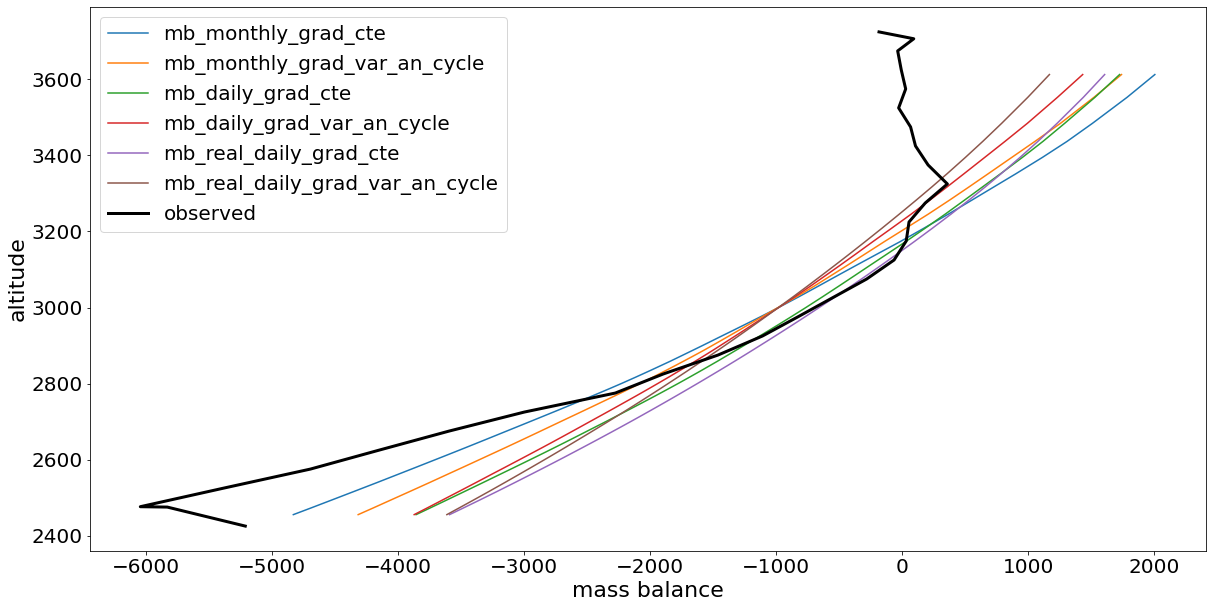

In [63]:
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10, 
                                  prepro_base_url=base_url,
                                  prepro_rgi_version='62')
gdir = gdirs[0]

# init_present_time_glacier(gdir) # if I use this, I have the wrong flowlines

# optimal values of mu_star for cte lapse rates
mu_star_opt = {'mb_monthly': 213.540352,
               'mb_daily':181.054877,
               'mb_real_daily':180.404965}
# optimal values of mu_star when using variable lapse rates:
# 'var_an_cycle'
mu_star_opt_var = {'mb_monthly': 195.304843, 
                            'mb_daily':167.214101, 
                            'mb_real_daily':159.901181}
pf = 2.5

# do this for all model types
for climate in [ 'ERA5dr','ERA5_daily']: # ONLY TEST it for ERA5dr or ERA5_daily!!!
    for mb_type in ['mb_monthly','mb_daily','mb_real_daily']:
        for grad_type in ['cte', 'var_an_cycle']:

            if grad_type =='var_an_cycle':
                fail_err_4 = (mb_type =='mb_monthly') and (climate == 'CRU')
                mu_star_opt = mu_star_opt_var
            else:
                fail_err_4 = False
            if climate =='ERA5dr':
                cfg.PARAMS['baseline_climate'] = 'ERA5dr'
                oggm.shop.ecmwf.process_ecmwf_data(gdir, dataset = "ERA5dr")
            elif climate == 'ERA5_daily':
                cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
                process_era5_daily_data(gdir)
            else:
                tasks.process_climate_data(gdir)
                pass
            # mb_type ='mb_daily'
            fail_err_1 = (mb_type =='mb_daily') and (climate !='ERA5dr')
            fail_err_2 = (mb_type =='mb_monthly') and (climate =='ERA5_daily')
            fail_err_3 = (mb_type =='mb_real_daily') and (climate !='ERA5_daily')


            if fail_err_1 or fail_err_2 or fail_err_3 or fail_err_4:
                with pytest.raises(InvalidParamsError):
                    mb_mod = TIModel(gdir, mu_star_opt[mb_type],
                                        mb_type = mb_type,
                                prcp_fac = pf,
                                t_solid = 0, t_liq =2, t_melt = 0, 
                                default_grad = -0.0065, 
                                grad_type = grad_type)
            else:
                # but this is just a test for reproducibility!
                mb_mod = TIModel(gdir, mu_star_opt[mb_type],
                                    mb_type = mb_type,
                prcp_fac = pf,
                t_solid = 0, t_liq =2, t_melt = 0, 
                default_grad = -0.0065, 
                grad_type = grad_type)
                # check climate and adapt if necessary
                mb_mod.historical_climate_qc_mod(gdir)

                #fls = gdir.read_pickle('inversion_flowlines') # model_flowlines does not work
                #glacier = FlowlineModel(fls)

                mbdf = gdir.get_ref_mb_data()

                #hgts = np.array([])
                #widths = np.array([])
                #for fl in glacier.fls:
                #    hgts = np.concatenate((hgts, fl.surface_h))
                #    widths = np.concatenate((widths, fl.widths_m))
                hgts, widths = gdir.get_inversion_flowline_hw()

                tot_mb = []
                refmb = []
                grads = hgts * 0
                for yr, mb in mbdf.iterrows():
                    refmb.append(mb['ANNUAL_BALANCE'])
                    mbh = (mb_mod.get_annual_mb(hgts, yr) * SEC_IN_YEAR *
                            cfg.PARAMS['ice_density'])
                    grads += mbh
                    tot_mb.append(np.average(mbh, weights=widths))
                grads /= len(tot_mb)

                #tot_mb = mb_mod.get_specific_mb(heights = hgts, 
                #                                widths = widths,


                #assert np.abs(utils.md(tot_mb, refmb)) < 50

                # Gradient THIS GIVES an error!!!
                # possibly because I use the HUSS flowlines ...
                # or is it because I use another calibration?
                dfg = gdir.get_ref_mb_profile().mean()

                # Take the altitudes below 3100 and fit a line
                dfg = dfg[dfg.index < 3100]
                pok = np.where(hgts < 3100)
                slope_obs, _, _, _, _ = linregress(dfg.index,
                                                   dfg.values)
                slope_our, _, _, _, _ = linregress(hgts[pok],
                                                   grads[pok])
                #np.testing.assert_allclose(slope_obs, slope_our,
                #                           rtol=0.15)


                plt.plot(grads,hgts, label = '{}_grad_{}'.format(mb_type, grad_type) )
                plt.ylabel('altitude')
plt.plot(gdir.get_ref_mb_profile().mean().values, 
         gdir.get_ref_mb_profile().mean().index, label= 'observed', color = 'black', lw = 3 )
plt.legend()
plt.xlabel('mass balance')
plt.savefig('./figures_hef/mb_profile_problem.pdf')